In [1]:
#

In [2]:
!pip install transformers==4.5.0 fugashi==1.1.0 ipadic==1.0.0
!pip install datasets

     |████████████████████████████████| 2.1 MB 5.3 MB/s 
     |████████████████████████████████| 486 kB 60.4 MB/s 
     |████████████████████████████████| 13.4 MB 25.3 MB/s 
     |████████████████████████████████| 895 kB 38.1 MB/s 
     |████████████████████████████████| 3.3 MB 28.0 MB/s 
  Created wheel for ipadic: filename=ipadic-1.0.0-py3-none-any.whl size=13556723 sha256=127f7e85af98eb08d7ca56e27fb6db24a22c41276dfc071d3ada923446075728
  Stored in directory: /root/.cache/pip/wheels/33/8b/99/cf0d27191876637cd3639a560f93aa982d7855ce826c94348b
Successfully built ipadic
     |████████████████████████████████| 311 kB 4.8 MB/s 
     |████████████████████████████████| 67 kB 6.2 MB/s 
     |████████████████████████████████| 1.1 MB 51.5 MB/s 
     |████████████████████████████████| 133 kB 49.1 MB/s 
     |████████████████████████████████| 243 kB 47.8 MB/s 
     |████████████████████████████████| 144 kB 51.5 MB/s 
     |████████████████████████████████| 271 kB 55.3 MB/s 
     |███████████████

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from transformers import BertJapaneseTokenizer, BertModel, BertConfig
from datasets import load_dataset
from torch.utils.data import DataLoader
import numpy as np
import re
from tqdm import tqdm
import matplotlib.pyplot as plt

INPUT_PATH = "/content/drive/My Drive/NLP/work/10_my_task/input/"  
OUTPUT_PATH = "/content/drive/My Drive/NLP/work/10_my_task/output/model/"  
MODEL_NAME = 'cl-tohoku/bert-base-japanese-whole-word-masking'

In [4]:
from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cpu


In [6]:
# トークナイザーのロード
tokenizer = BertJapaneseTokenizer.from_pretrained(MODEL_NAME) 

Downloading:   0%|          | 0.00/258k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/110 [00:00<?, ?B/s]

In [7]:
# 入力
MAX_LENGTH = 32
def tokenize(batch):
    return tokenizer(batch["text1"], batch["text2"], padding='max_length', truncation=True, max_length=MAX_LENGTH) # , return_tensors='pt'

train_data = load_dataset("csv", data_files=INPUT_PATH+"train_posi_nega.csv", column_names=["text1", "text2", "label"], split="train", encoding='utf-8', header=0)
train_data = train_data.map(tokenize, batched=True, batch_size=len(train_data))
train_data.set_format("torch", columns=["input_ids", "label", "attention_mask", "token_type_ids"])

val_data = load_dataset("csv", data_files=INPUT_PATH+"val_posi_nega.csv", column_names=["text1", "text2", "label"], split="train", encoding='utf-8', header=0)
val_data = val_data.map(tokenize, batched=True, batch_size=len(val_data))
val_data.set_format("torch", columns=["input_ids", "label", "attention_mask", "token_type_ids"])

test_data = load_dataset("csv", data_files=INPUT_PATH+"test_posi_nega.csv", column_names=["text1", "text2", "label"], split="train", encoding='utf-8', header=0)
test_data = test_data.map(tokenize, batched=True, batch_size=len(test_data))
test_data.set_format("torch", columns=["input_ids", "label", "attention_mask", "token_type_ids"])

print(train_data.shape, val_data.shape, test_data.shape)

Using custom data configuration default-d044c561982b459b


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-d044c561982b459b/0.0.0/6b9057d9e23d9d8a2f05b985917a0da84d70c5dae3d22ddd8a3f22fb01c69d9e. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?ba/s]

Using custom data configuration default-1fcbaa7f562e614a


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-1fcbaa7f562e614a/0.0.0/6b9057d9e23d9d8a2f05b985917a0da84d70c5dae3d22ddd8a3f22fb01c69d9e. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?ba/s]

Using custom data configuration default-58e3668c2fa26061


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-58e3668c2fa26061/0.0.0/6b9057d9e23d9d8a2f05b985917a0da84d70c5dae3d22ddd8a3f22fb01c69d9e. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?ba/s]

(56, 6) (14, 6) (18, 6)


In [8]:
# データ分割(バッチ)
BATCH_SIZE = 7

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)

In [9]:
# モデル定義
class DocCls(nn.Module):
  def __init__(self, bert):
    super(DocCls, self).__init__()
    self.bert = bert
    self.cls = nn.Linear(768,2)
  def forward(self, x1, x2, x3):
    output = self.bert(input_ids=x1, attention_mask=x2, token_type_ids=x3) 
    batch_size = len(output[0])
    h0 = [output[0][i][0] for i in range(batch_size)]
    h0 = torch.stack(h0, dim=0)
    h1 = self.cls(h0)
    return h1

In [10]:
# モデル生成(全層の学習)
EPOCH_SIZE = 20
LEARNING_RATE = 0.001

bert = BertModel.from_pretrained(MODEL_NAME)
model = DocCls(bert).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE)
#print(model)

Downloading:   0%|          | 0.00/479 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/445M [00:00<?, ?B/s]

In [11]:
# 学習
model.train()

acc_hist = []
loss_hist = []
acc_val_hist = []
best_score = 0
best_epoch = 0

for epoch_num in range(EPOCH_SIZE):
  collect_sum = 0
  loss_sum = 0.0

  for i, batch in enumerate(tqdm(train_loader)): 
    x1 = batch['input_ids'].to(device)
    x2 = batch['attention_mask'].to(device)
    x3 = batch['token_type_ids'].to(device)
    y = batch['label'].to(device)
    output = model(x1, x2, x3)
    # print(output)
    loss = criterion(output, y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    loss_sum += loss.item()
    # print(loss_sum)

    ans = torch.argmax(output, dim=1)
    collect_sum += sum(ans==y).item()
    #print(ans==y)

  # 精度(epoch毎)
  acc_hist.append(collect_sum/len(train_data))
  loss_hist.append(loss_sum)

  # 検証(epoch毎)
  with torch.no_grad():
      x1 = val_data['input_ids'].to(device)
      x2 = val_data['attention_mask'].to(device)
      x3 = val_data['token_type_ids'].to(device)
      output = model(x1, x2, x3)
      ans = torch.argmax(output, dim=1)
      correct = sum(ans==val_data['label'].to(device)).item()
      val_score = correct/len(val_data)
      acc_val_hist.append(val_score)
      
      # モデルの保存
      if val_score > best_score:
        best_score = val_score
        best_epoch = epoch_num
        print(f"精度(検証)：{val_score} (epoch={epoch_num})")
        torch.save(model.state_dict(), OUTPUT_PATH + "epoch_" + str(epoch_num) + ".model")

100%|██████████| 8/8 [00:21<00:00,  2.74s/it]


精度(検証)：0.8571428571428571 (epoch=0)


100%|██████████| 8/8 [00:19<00:00,  2.40s/it]


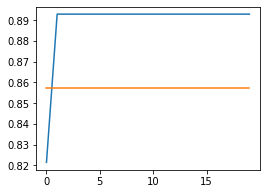

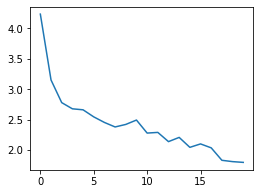

In [12]:
# 可視化
plt.figure(figsize=(4,3))
plt.plot(acc_hist)
plt.plot(acc_val_hist)
plt.show()

plt.figure(figsize=(4,3))
plt.plot(loss_hist)
plt.show()

In [14]:
# config(bert)
model.bert.save_pretrained(OUTPUT_PATH + 'last.bin')

In [15]:
# モデルロード
config = BertConfig.from_json_file(OUTPUT_PATH + '/last.bin/config.json')
bert = BertModel(config)
model2 = DocCls(bert).to(device)
model2.load_state_dict(torch.load(OUTPUT_PATH + f'epoch_{best_epoch}.model'))
#print(model2)

<All keys matched successfully>

In [16]:
# テスト
model2.eval()

with torch.no_grad():
    x1 = test_data['input_ids'].to(device)
    x2 = test_data['attention_mask'].to(device)
    x3 = test_data['token_type_ids'].to(device)
    output = model2(x1, x2, x3)
    ans = torch.argmax(output, dim=1)
    correct = sum(ans == test_data['label'].to(device))
    print(f"精度：{correct/len(test_data)}")

精度：0.8333333134651184
